<a href="https://colab.research.google.com/github/andreregino/tutorial-2-kg-with-llm/blob/main/Tutorial_2_KG_Generation_with_LLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geração de Triplas com LLMs

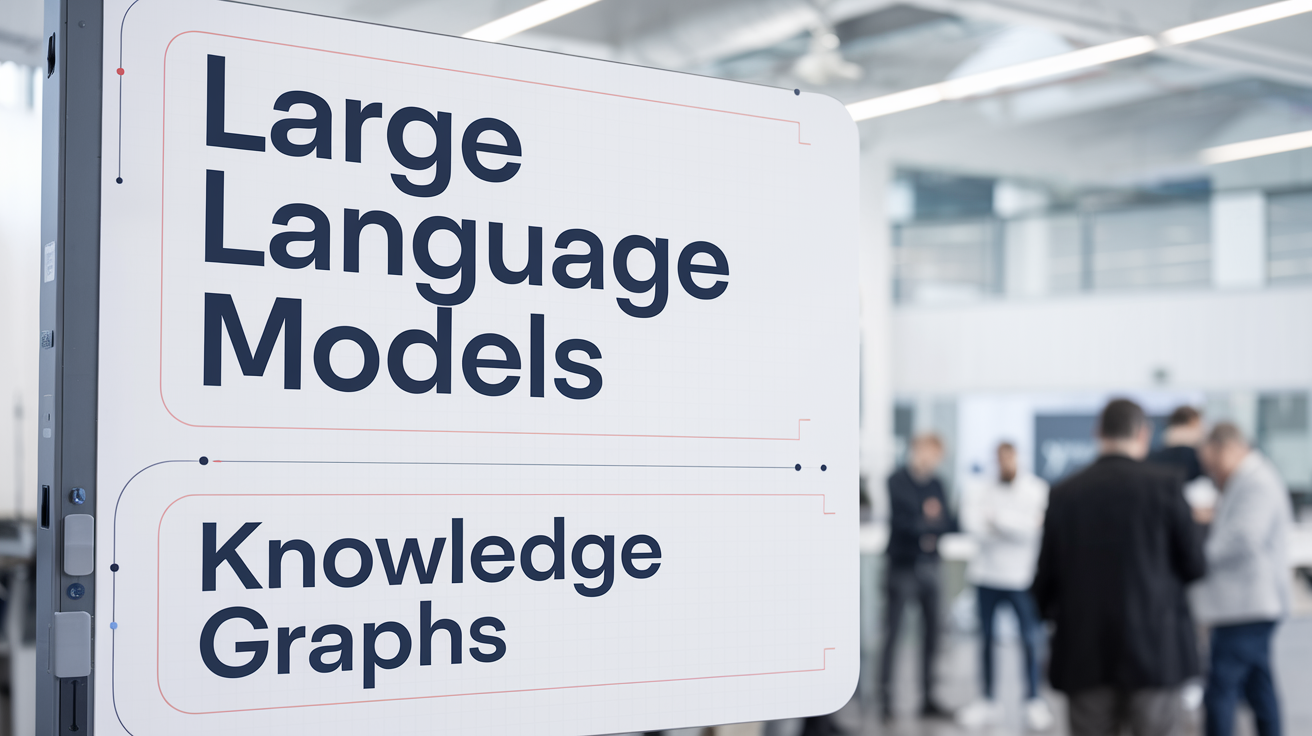

## 1) Introdução

Neste tutorial, você aprenderá a gerar triplas RDF utilizando modelos de linguagem (LLMs). O foco será na criação de triplas que sejam consistentes e possam ser integradas a um Grafo de Conhecimento (KG) existente ou novo.


Usaremos as seguintes ferramentas e bibliotecas:


*   Groq - Provedor de LLMs
*   Llama
* RDF Grapher
* RDF Visualizer
* Pandas

## 2) Configuração do Ambiente

### 2.1) Instalação de Bibliotecas

O comando `!pip install -q groq pandas rdflib ontospy pyvis` instala silenciosamente (sem exibir a saída no terminal devido à flag -q, que significa "quiet") as bibliotecas Python groq, pandas, rdflib, ontospy, e pyvis no ambiente do Google Colab.

In [1]:
!pip install -q groq pandas rdflib ontospy pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.8 MB/s eta 0:00:00


### 2.2) Imports Necessários

Após instalar as bibliotecas, importe os pacotes necessários:

In [2]:
import pandas as pd  #  manipulação de dados em estruturas tabulares, como DataFrames, facilitando a análise e processamento de dados.
from rdflib import Graph, Literal, RDF, URIRef  # biblioteca para trabalhar com grafos RDF em Python, permitindo a criação, manipulação e consulta de triplas RDF.
from rdflib.namespace import FOAF, XSD  # FOAF é um vocabulário RDF para descrever pessoas e suas relações, e XSD define tipos de dados XML Schema, ambos usados para criar triplas RDF.
from google.colab import userdata  # acessar e gerenciar Secrets (dados sensíveis, como chaves de API) armazenados no ambiente do Colab.
import ontospy  # trabalhar com ontologias e grafos RDF, facilitando a exploração e visualização de ontologias.
import networkx as nx  # criação, manipulação e estudo da estrutura, dinâmica e funções de grafos complexos.
import matplotlib.pyplot as plt  # criar visualizações gráficas, como gráficos e plots, muito útil para análise de dados e visualização de grafos.
from pyvis.network import Network  # criar e visualizar grafos interativos na web, útil para representar grafos de conhecimento de forma dinâmica.
from groq import Groq  # interagir com a API do Groq, facilitando a geração de triplas RDF a partir de LLMs.
import requests  # fazer requisições HTTP em Python, usada para interagir com APIs web e obter dados de fontes externas.
import random  # gerar números aleatórios e realizar operações que envolvem aleatoriedade, como embaralhar dados ou selecionar amostras aleatórias.

### 2.3) Geração e Configuração da Chave de Acesso do Groq

**O que é a chave de API Groq e para que ela é usada?**
A chave de API do Groq é um token de autenticação que permite a você acessar os serviços e modelos oferecidos pela plataforma Groq.

Com essa chave, você pode enviar requisições à API do Groq para gerar triplas RDF, interagir com modelos de linguagem, e realizar outras tarefas de processamento de linguagem natural que são suportadas pela plataforma.



**Como gerá-la?**

1. Acesse o [site da Groq](https://console.groq.com/playground) e crie uma conta.
2. Navegue até a seção de [API keys](https://console.groq.com/keys).
3. Lá, você encontrará a opção para gerar uma nova chave de API.
4. Copie a chave gerada para usá-la aqui.


 **Quais modelos consigo acessar via Groq?**

A plataforma Groq oferece acesso a uma variedade de LLMs gratuitamente (até o momento). Na seção 2.4 abaixo eu exibo todos os modelos disponíveis no momento.


**Como adicionar a chave da API do Groq no Secrets do Google Colab?**

Para manter a chave de API segura e acessível apenas pelo seu código, você pode armazená-la nos *Secrets* do Google Colab:

1. No menu do Google Colab, clique no ícone em formato de chave.
2. No campo para adicionar um novo segredo, insira o nome `GROQ_TOKEN`.
3. Cole a chave de API que você copiou anteriormente.
4. Salve o token.
5. Certifique-se que ele pode ser visualizado neste notebook do Google Colab ao deixar habilitado o slider de "Acesso ao notebook"

Dessa forma, a chave será armazenada de forma segura e acessível apenas no seu notebook do Colab. Você terá um resultado parecido com o da imagem abaixo:


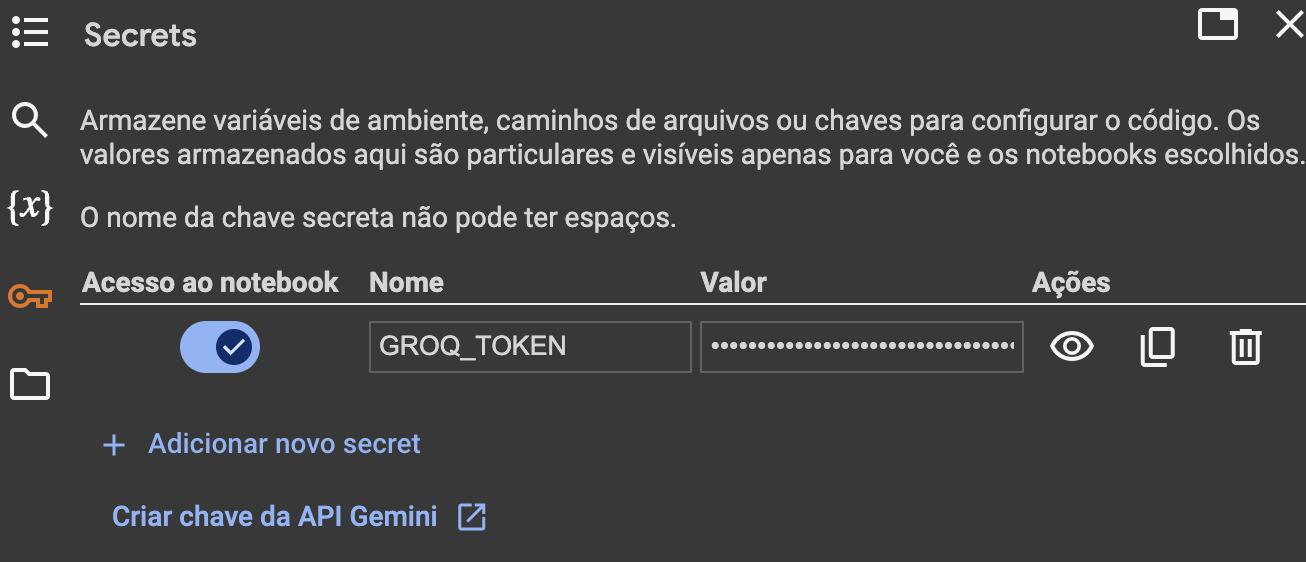

**Como adicionar a chave no código?**

Agora que a chave de API está armazenada nos *Secrets* do Google Colab, você pode acessá-la diretamente no seu código usando o seguinte comando em Python:


In [3]:
GROQ_TOKEN = userdata.get('GROQ_TOKEN') # adicione sua chave aqui

### 2.4) Consultando os Modelos Disponíveis no Groq

**Como sei se deu tudo certo na configuração?**

Depois de realizar todos os passos acima, execute o código abaixo. Caso seja retornado a lista de modelos disponíveis no Groq, a sua chave está configurada, devidamente guardada no Secrets e utilizável nas suas chamadas de API.

In [4]:
url = "https://api.groq.com/openai/v1/models"

headers = {
    "Authorization": f"Bearer {GROQ_TOKEN}",
    "Content-Type": "application/json"
}

response = requests.get(url, headers=headers)

for models in response.json()["data"]:
  print("Modelo:", models["id"], "com tamanho de contexto", models["context_window"], "tokens")

Modelo: gemma2-9b-it com tamanho de contexto 8192 tokens
Modelo: gemma-7b-it com tamanho de contexto 8192 tokens
Modelo: whisper-large-v3 com tamanho de contexto 448 tokens
Modelo: llama3-groq-70b-8192-tool-use-preview com tamanho de contexto 8192 tokens
Modelo: llama-3.1-70b-versatile com tamanho de contexto 131072 tokens
Modelo: mixtral-8x7b-32768 com tamanho de contexto 32768 tokens
Modelo: llama3-8b-8192 com tamanho de contexto 8192 tokens
Modelo: llama3-groq-8b-8192-tool-use-preview com tamanho de contexto 8192 tokens
Modelo: llama-guard-3-8b com tamanho de contexto 8192 tokens
Modelo: llama-3.1-8b-instant com tamanho de contexto 131072 tokens
Modelo: llama3-70b-8192 com tamanho de contexto 8192 tokens
Modelo: distil-whisper-large-v3-en com tamanho de contexto 448 tokens


## 3) Exemplo 1: Atualizando um Grafo de Conhecimento de Produtos

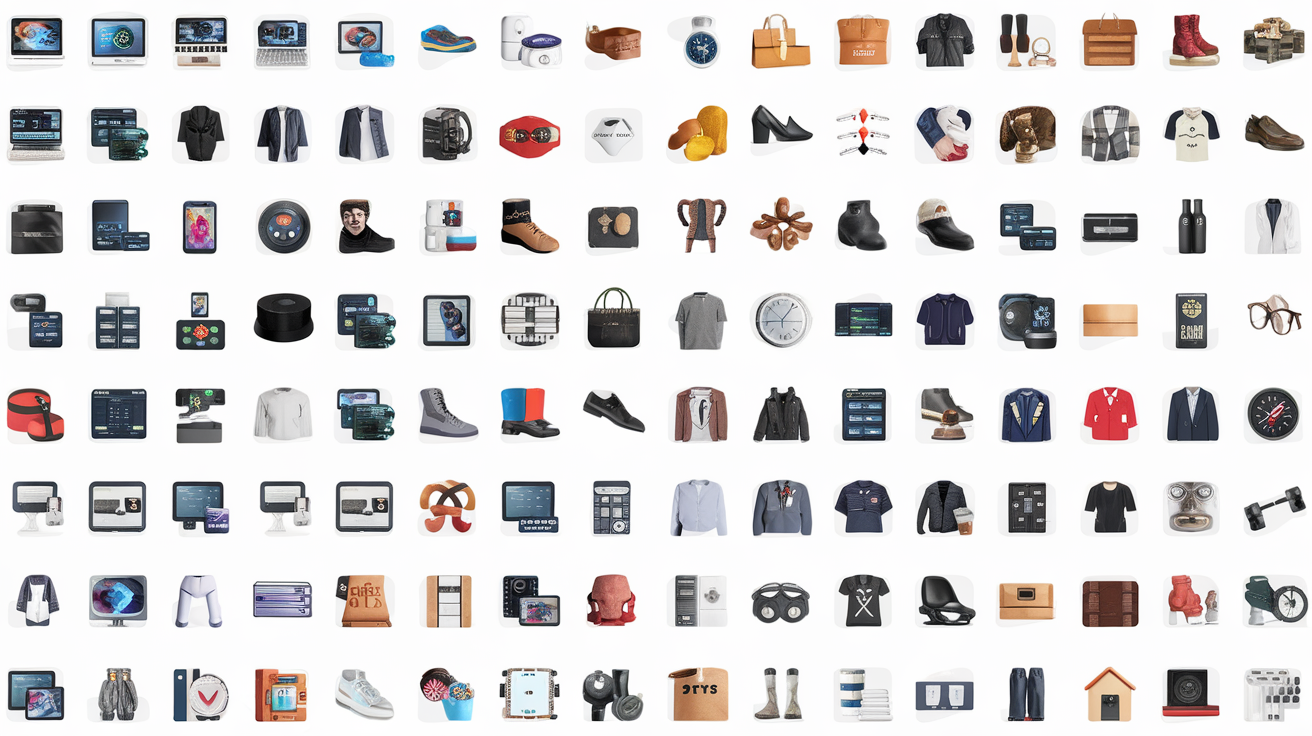

Neste exemplo, vamos explorar como atualizar um grafo de conhecimento de produtos utilizando um conjunto de técnicas que envolvem desde a criação de triplas com a biblioteca `rdflib` até a geração de triplas usando LLMs. Nosso objetivo é entender o processo de transformação de dados de um e-commerce em um KGs, comparando uma abordagem mais tradicional e uma mais "moderna".


### 3.1) Criação de um Grafo de Conhecimento Inicial



**Passo 1:**

- Iniciaremos com um dataset sintético simples, composto por **3 registros** e **3 colunas**.
- Os registros representam produtos de um e-commerce, com as seguintes colunas:
  - **Título do Produto**
  - **Categoria**
  - **Descrição**
- O dataset está em formato **JSON** e, para facilitar a visualização e manipulação, vamos transformá-lo em um `DataFrame` usando a biblioteca `pandas`. O `DataFrame` é só uma estrutura de dados que ajuda na visualização de tabulares.


In [5]:
data = {
    "produto": ["Notebook LG i7", "Smartphone Samsung s20 FE", "Tablet iPad"],
    "categoria": ["Eletrônicos", "Eletrônicos", "Eletrônicos"],
    "descricao": [
        "Notebook com 8GB de RAM e 256GB de SSD.",
        "Smartphone com câmera de 12MP e 64GB de armazenamento.",
        "Tablet com tela de 10 polegadas e 128GB de armazenamento."
    ]
}

df = pd.DataFrame(data)
df.head()

,produto,categoria,descricao
0,Notebook LG i7,Eletrônicos,Notebook com 8GB de RAM e 256GB de SSD.
1,Smartphone Samsung s20 FE,Eletrônicos,Smartphone com câmera de 12MP e 64GB de armaze...
2,Tablet iPad,Eletrônicos,Tablet com tela de 10 polegadas e 128GB de arm...


**Passo 2:**

- Com o dataset estruturado, utilizaremos a biblioteca `rdflib` para **criar triplas RDF** a partir dos dados.
- As triplas serão exibidas no formato **Turtle**.
- Para evitar a criação de uma nova ontologia, reusaremos **ontologias e vocabulários já existentes**, como **FOAF** e **DCTERMS**.


In [6]:
from rdflib import Graph, Literal, RDF, URIRef
from rdflib.namespace import FOAF, XSD, DCTERMS

# Definindo o grafo
g = Graph()

# Definindo namespaces
n = URIRef("http://example.org/product/")

# Adicionando triplas ao grafo
for index, row in df.iterrows():
    produto = URIRef(n + row["produto"].replace(" ", "_"))
    g.add((produto, RDF.type, FOAF.Document))
    g.add((produto, FOAF.name, Literal(row["produto"], datatype=XSD.string)))
    g.add((produto, FOAF.topic, Literal(row["categoria"], datatype=XSD.string)))
    g.add((produto, DCTERMS.description, Literal(row["descricao"], datatype=XSD.string)))

# Serializando o grafo em formato Turtle
print(g.serialize(format="turtle"))


@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix foaf: <http://xmlns.com/foaf/0.1/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

<http://example.org/product/Notebook_LG_i7> a foaf:Document ;
    dcterms:description "Notebook com 8GB de RAM e 256GB de SSD."^^xsd:string ;
    foaf:name "Notebook LG i7"^^xsd:string ;
    foaf:topic "Eletrônicos"^^xsd:string .

<http://example.org/product/Smartphone_Samsung_s20_FE> a foaf:Document ;
    dcterms:description "Smartphone com câmera de 12MP e 64GB de armazenamento."^^xsd:string ;
    foaf:name "Smartphone Samsung s20 FE"^^xsd:string ;
    foaf:topic "Eletrônicos"^^xsd:string .

<http://example.org/product/Tablet_iPad> a foaf:Document ;
    dcterms:description "Tablet com tela de 10 polegadas e 128GB de armazenamento."^^xsd:string ;
    foaf:name "Tablet iPad"^^xsd:string ;
    foaf:topic "Eletrônicos"^^xsd:string .




### 3.2) Visualização do Grafo de Conhecimento Inicial

**Passo 3:**

- Agora que temos as triplas geradas, vamos **visualizar o grafo** resultante.
- Utilizaremos dois sites especializados em visualização de grafos RDF:
  - [**RDF Grapher**](https://www.ldf.fi/service/rdf-grapher)
  - [**RDF Visualizer**](https://issemantic.net/rdf-visualizer)

Para criar as visualizações abaixo, basta copiar as triplas RDF em formato Turtle acima em cada um dos sites e pedir para gerar as visualizações.

In [7]:
# sujeito, predicado e objeto de cada tripla
for s, p, o in g:
  print(s, p, o)

http://example.org/product/Notebook_LG_i7 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://xmlns.com/foaf/0.1/Document
http://example.org/product/Tablet_iPad http://xmlns.com/foaf/0.1/name Tablet iPad
http://example.org/product/Notebook_LG_i7 http://xmlns.com/foaf/0.1/topic Eletrônicos
http://example.org/product/Notebook_LG_i7 http://xmlns.com/foaf/0.1/name Notebook LG i7
http://example.org/product/Tablet_iPad http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://xmlns.com/foaf/0.1/Document
http://example.org/product/Notebook_LG_i7 http://purl.org/dc/terms/description Notebook com 8GB de RAM e 256GB de SSD.
http://example.org/product/Tablet_iPad http://purl.org/dc/terms/description Tablet com tela de 10 polegadas e 128GB de armazenamento.
http://example.org/product/Smartphone_Samsung_s20_FE http://xmlns.com/foaf/0.1/name Smartphone Samsung s20 FE
http://example.org/product/Smartphone_Samsung_s20_FE http://purl.org/dc/terms/description Smartphone com câmera de 12MP e 64GB de arma

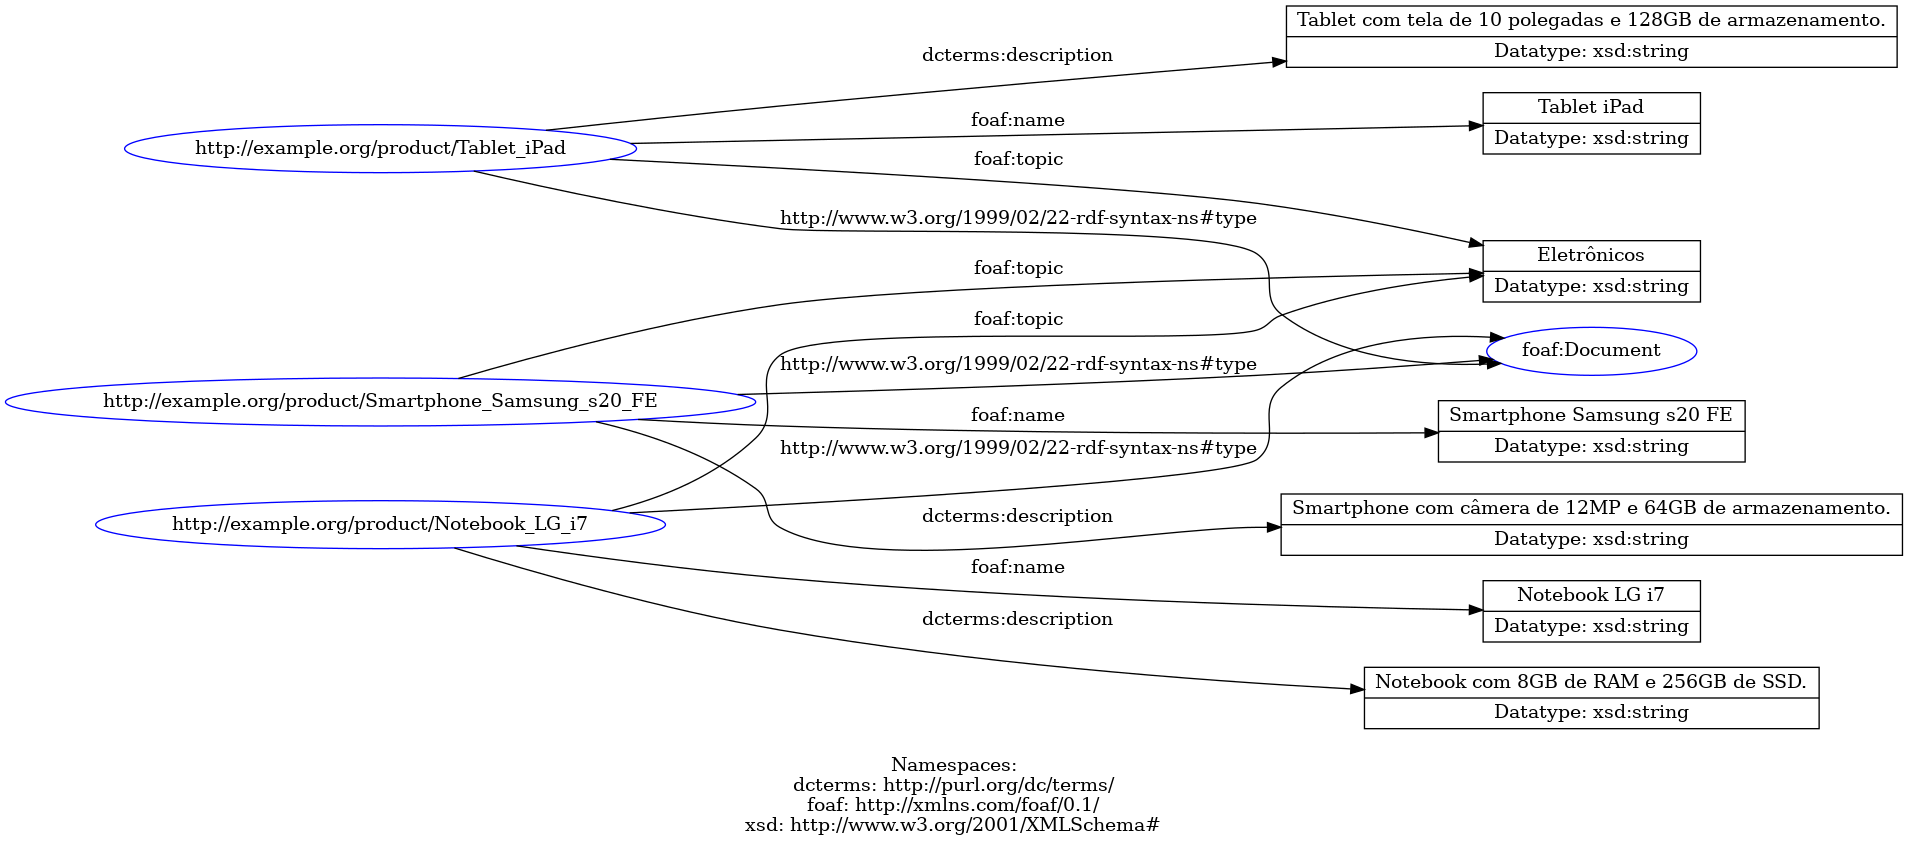

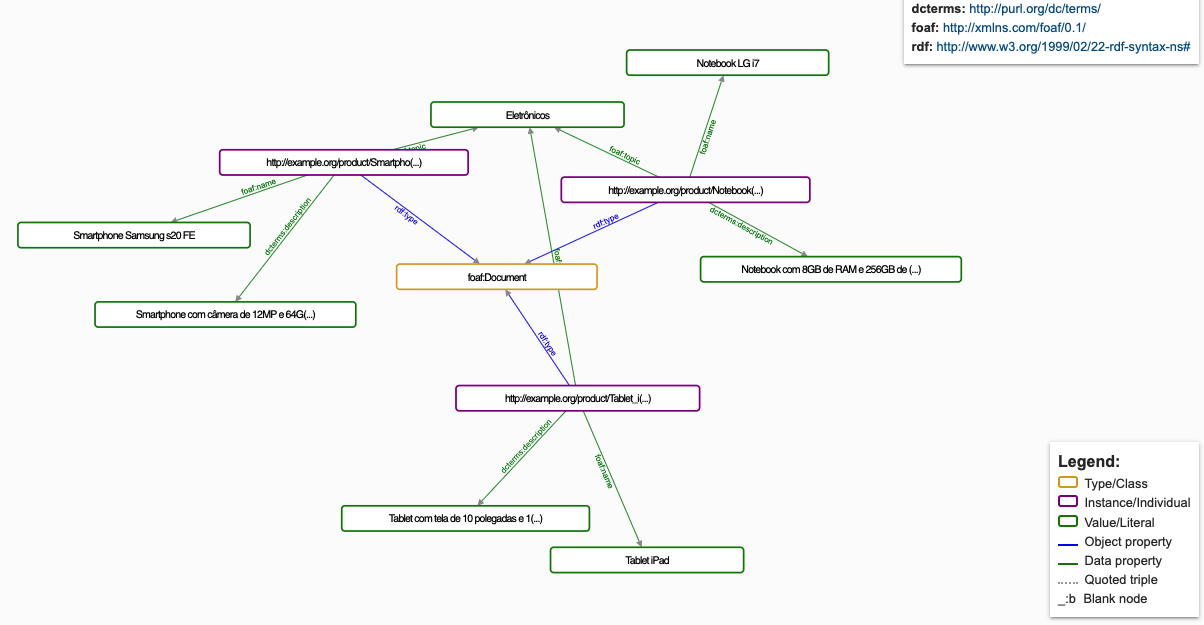

### 3.3) Atualizando o Grafo de Conhecimento com Novas Triplas

**Passo 4:**

- Com o grafo inicial criado, o próximo passo é testar a **criação de novas triplas** para produtos diferentes com categorias diferentes.
- Desta vez, ao invés de utilizar `rdflib` para transformar JSON em RDF, vamos **usar LLMs**.
- Para isso, criaremos um novo dataset contendo **3 frases** que descrevem produtos.



In [8]:
dataset_inicial = [
    "Ração Whiskas para gato, 2 kg",
    "Par de retrovisores Metagal preto metálico para Honda Fit 2022",
    "Camiseta Bob Esponja tamanho M azul"
]


#### 3.3.1) Prompt

**Passo 5:**

- Cada frase será adicionada iterativamente em um **prompt**, que incluirá:
  - **Instruções iniciais**
  - **Exemplos (Few-shots)** que exemplificam o formato das triplas.
- O objetivo é gerar triplas semelhantes às criadas pelo `rdflib`, mas desta vez a partir de textos não estruturados do dataset.


In [9]:
def prompt_direcoes_exemplo_1():
  return "You will receive a sentence. Your task is to create RDF triples based on that sentence. \n \
  Only return the RDF triples. Avoid explanation. \
  I will provide two examples. Complete the third. \n \
  \Sentence: Notebook LG i7 com 8GB de RAM e 256GB de SSD. \n\
  \RDF Triples: <http://example.org/product/Notebook_LG_i7> a foaf:Document . \
     <http://example.org/product/Notebook_LG_i7> dcterms:description 'Notebook com 8GB de RAM e 256GB de SSD.'^^xsd:string . \
     <http://example.org/product/Notebook_LG_i7>  foaf:name 'Notebook LG i7'^^xsd:string . \
    <http://example.org/product/Notebook_LG_i7> foaf:topic 'Eletrônicos'^^xsd:string . \
  \n\n\n \
  \
  Sentence: Tablet iPad	Eletrônicos	Tablet com tela de 10 polegadas e 128GB de armazenamento. \n\
  RDF Triples: <http://example.org/product/Tablet_iPad> a foaf:Document . \
    <http://example.org/product/Tablet_iPad> dcterms:description 'Tablet com tela de 10 polegadas e 128GB de armazenamento.'^^xsd:string . \
    <http://example.org/product/Tablet_iPad> foaf:name 'Tablet iPad'^^xsd:string . \
    <http://example.org/product/Tablet_iPad> foaf:topic 'Eletrônicos'^^xsd:string . \
    \n\n\n"

def prompt_final(frase):
  new_prompt = prompt_direcoes_exemplo_1()
  new_prompt += "\nSentence: " + frase
  new_prompt += "\nRDF Triples: "
  return new_prompt


### 3.3.2) Conexão com o Groq

**Passo 6:**

- Com o prompt preparado, faremos a **conexão com a API do Groq**.
- Usaremos uma função que passa o prompt como parâmetro, juntamente com o modelo de LLM que desejamos utilizar.


In [10]:
def query_to_model_groq(model_name, content):
  client = Groq(
      api_key=GROQ_TOKEN,
  )

  chat_completion = client.chat.completions.create(
      messages=[
          {
              "role": "user",
              "content": content,
          }
      ],
      model=model_name,
  )

  return chat_completion.choices[0].message.content

query_to_model_groq("llama3-70b-8192", "What is the biggest Brazilian city?") # exemplo de chamada da função

"The biggest Brazilian city is São Paulo. It is the capital of the state of São Paulo and is located in the southeastern part of the country. São Paulo is the largest city in Brazil, both in terms of population and economy. It is a megacity with a population of over 22 million people in its metropolitan area, making it one of the largest cities in the world.\n\nSão Paulo is a major economic and cultural hub in Brazil, known for its vibrant cultural scene, rich history, and diverse gastronomy. The city is home to many important landmarks, such as the Ibirapuera Park, the São Paulo Cathedral, and the Paulista Avenue, as well as a number of museums, galleries, and cultural institutions.\n\nThe city is also a major business center, with a strong presence of industries such as finance, technology, and manufacturing. It is also a major hub for transportation, with two international airports and a comprehensive public transportation system.\n\nOverall, São Paulo is a fascinating and dynamic c

### 3.3.3) Gerando as Novas Triplas

**Passo 7:**

- Finalmente, com a **conexão estabelecida com o modelo Llama 3 70B** e o prompt definido, vamos gerar as novas triplas.
- Essas triplas serão **comparadas** com as geradas pelo `rdflib` para verificar sua similaridade, demonstrando que **LLMs** podem ser uma ferramenta eficiente para **gerar triplas a partir de texto**.


In [11]:
triples_to_be_added = []
for frase in dataset_inicial:
    prompt = prompt_final(frase)
    #print(prompt)
    answer = query_to_model_groq("llama3-70b-8192", prompt)

    triples_to_be_added.append(answer)
    print(f"\n\nFrase: {frase}\nTriplas: {answer}")



Frase: Ração Whiskas para gato, 2 kg
Triplas: <http://example.org/product/Racao_Whiskas_para_gato> a foaf:Document .
<http://example.org/product/Racao_Whiskas_para_gato> dcterms:description 'Ração para gato, 2 kg'^^xsd:string .
<http://example.org/product/Racao_Whiskas_para_gato> foaf:name 'Ração Whiskas para gato'^^xsd:string .
<http://example.org/product/Racao_Whiskas_para_gato> foaf:topic 'Alimentos para Animais'^^xsd:string .


Frase: Par de retrovisores Metagal preto metálico para Honda Fit 2022
Triplas: <http://example.org/product/Par_de_retrovisores_Metagal> a foaf:Document . 
<http://example.org/product/Par_de_retrovisores_Metagal> dcterms:description 'Par de retrovisores preto metálico para Honda Fit 2022'^^xsd:string . 
<http://example.org/product/Par_de_retrovisores_Metagal> foaf:name 'Par de retrovisores Metagal'^^xsd:string . 
<http://example.org/product/Par_de_retrovisores_Metagal> foaf:topic 'Pecas'^^xsd:string .


Frase: Camiseta Bob Esponja tamanho M azul
Triplas: <h

## 4) Exemplo 2: Criando Triplas de Perguntas e Respostas de Comércio Eletrônico

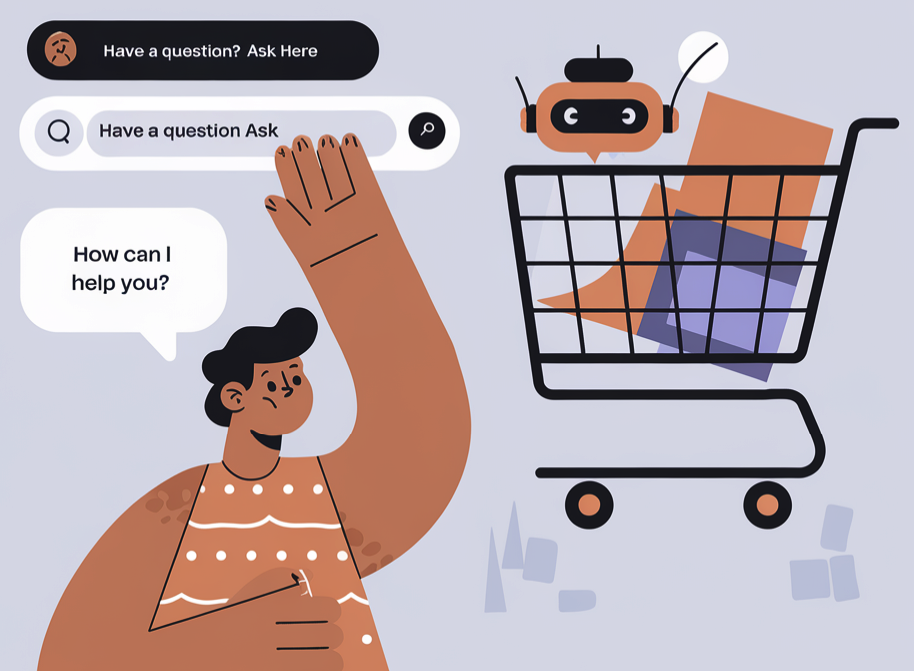

Neste exemplo, vamos explorar como transformar um conjunto de perguntas e respostas sobre produtos de um e-commerce em triplas RDF, respeitando as propriedades e classes de uma ontologia específica. Este processo inclui um passo adicional de sumarização antes da geração das triplas.


### 4.1) Criação das Perguntas e Respostas

**Passo 1:**

- Iniciaremos com a **criação do dataset** de perguntas e respostas.
- O dataset terá **3 colunas**:
  - **ID do Produto**
  - **Pergunta**
  - **Resposta**
- Serão **10 linhas**, cada uma associada a um produto específico.
- A geração do dataset envolve a combinação aleatória de **5 perguntas** e **4 respostas**, resultando no dataset final de 10 linhas.
- O **ID do produto** é um número aleatório entre 1000 e 9999.
- Usaremos `pandas` para criar um `DataFrame` e **visualizar o dataset inicial** de forma clara.


In [12]:
# Function to generate a random product ID
def generate_product_id():
    return f"PROD{random.randint(1000, 9999)}"

# Function to generate compatibility questions and answers
def generate_compatibility_data():
    questions = [
        "Is the product compatible with the Honda Civic 2012/2013?",
        "Does the product fit the Tesla 2019?",
        "Is the product suitable for the Audi TT 2013?",
        "Is it compatible with my 2020 Ford Focus?",
        "If I buy it, is it gonna fit my 1987 Chevrolet Impala"
    ]
    answers = [
        "Yes",
        "No",
        "You can buy it, it fits",
        "No, unfortunately it does not fit"
    ]

    product_id = generate_product_id()
    question = random.choice(questions)
    answer = random.choice(answers)
    return {"product_id": product_id, "question": question, "answer": answer}

# Generate 10 rows of dataset
data = []
for _ in range(10):
    compatibility_data = generate_compatibility_data()
    data.append(compatibility_data)

df = pd.DataFrame(data)
df.head()

,product_id,question,answer
0,PROD4483,Is it compatible with my 2020 Ford Focus?,No
1,PROD8097,"If I buy it, is it gonna fit my 1987 Chevrolet...","No, unfortunately it does not fit"
2,PROD5409,Is it compatible with my 2020 Ford Focus?,Yes
3,PROD2591,Does the product fit the Tesla 2019?,"You can buy it, it fits"
4,PROD6926,Is the product compatible with the Honda Civic...,No


### 4.2) Sumarização

**Passo 2:**

- Com o dataset em mãos, o próximo passo é criar um **prompt de sumarização**.
- O prompt será composto por:
  - Uma **parte inicial** com instruções claras de como realizar a sumarização.
  - Uma **parte de few shots**, exemplificando como um produto, uma pergunta e uma resposta podem ser sumarizados.
- O objetivo é transformar as informações em uma **frase única**, que descreva a compatibilidade entre o produto da pergunta e resposta com o automóvel do comprador.


In [13]:
initial_directions = '''For each example below, you should summarize if there is a compatibility between the mentioned car in the question and the customer product in the Summarized Compatibility field.
  To answer it, I will provide 3 fields: the product ID, the question containing the car and the answer stating if the product and the car are compatible.
  You should always answer using the product ID, the car name and the compatibility.
  Avoid using any car specification that are not in the question or in the answer.
  Avoid using any product specification that is not written in the question or answer.
  The answer should be placed after the string 'Summarized Compatibility:'.
  If the product and the car are not compatible, just answer that they are not compatible. Im going to provide you three examples.
  Complete the fourth.
  '''

few_shots_examples = '''
  Product ID: MB121391021 \
  Question: Hey buddy, does it fit for the hb20 2015 original radio?
  Answer: I hope you are okay! Yes, it fits, perfectly.
  Summarized Compatibility: The MB121391021 fits in hb20 2015
   ###
  Product ID: MLB134232121
  Question: Hi! Does it fit in 2003 Fiesta 2004 model?.
  Answer: Unfortunately this kit is not compatible with your car due to the frame not being compatible.
  Summarized Compatibility: The MLB134232121 is not compatible with Fiesta 2003/2004
  ###
  Product ID: MLB12718279
  Question: Does it work on Santana 99/2000 with power steering and air conditioning?
  Answer: Yes, it fits, perfectly.
  Summarized Compatibility: The MLB12718279 fits in santana 99/2000
  ###
  '''

def prompt_direcoes_sumarizacao_exemplo_2():
  return initial_directions + few_shots_examples

def prompt_final_sumarizacao_exemplo_2(fields):
  new_prompt = prompt_direcoes_sumarizacao_exemplo_2()
  new_prompt += "\nProduct ID: " + fields['product_id']
  new_prompt += "\nQuestion: " + fields['question']
  new_prompt += "\nAnswer: " + fields['answer']
  new_prompt += "\nSummarized Compatibility: "

  return new_prompt

**Passo 3:**

- Realizamos a **sumarização** chamando novamente a API do Groq, usando o modelo **Llama 3 70B**.
- O resultado será um conjunto de frases sumarizadas, que servirão de base para a próxima etapa.


In [14]:
# querying the model and generating the summarized sentence

summarized_sentences = []
for coluna, linha in df.iterrows():
    #print(df[coluna])
    prompt = prompt_final_sumarizacao_exemplo_2(linha)
    summarized_sentence = query_to_model_groq("llama3-70b-8192", prompt)

    summarized_sentences.append(summarized_sentence)
    print(f"\n\nProduct ID: {linha['product_id']} Question: {linha['question']} Answer: {linha['answer']} \nSummarization: {summarized_sentence}")



Product ID: PROD4483 Question: Is it compatible with my 2020 Ford Focus? Answer: No 
Summarization: The PROD4483 is not compatible with Ford Focus 2020


Product ID: PROD8097 Question: If I buy it, is it gonna fit my 1987 Chevrolet Impala Answer: No, unfortunately it does not fit 
Summarization: The PROD8097 is not compatible with Chevrolet Impala 1987


Product ID: PROD5409 Question: Is it compatible with my 2020 Ford Focus? Answer: Yes 
Summarization: Summarized Compatibility: The PROD5409 fits in Ford Focus 2020


Product ID: PROD2591 Question: Does the product fit the Tesla 2019? Answer: You can buy it, it fits 
Summarization: The PROD2591 fits in Tesla 2019


Product ID: PROD6926 Question: Is the product compatible with the Honda Civic 2012/2013? Answer: No 
Summarization: The PROD6926 is not compatible with Honda Civic 2012/2013


Product ID: PROD4632 Question: Does the product fit the Tesla 2019? Answer: No, unfortunately it does not fit 
Summarization: The PROD4632 is not com

### 4.3) Geração das Triplas

**Passo 4:**

- Antes de gerar as triplas, precisamos definir uma **lista de classes e propriedades** que as triplas devem respeitar.
- Essa lista será utilizada para garantir que a **LLM** gere triplas que estejam alinhadas com a **ontologia** que estamos utilizando.


In [15]:
ontology_parts = {
    "Classes": ["Car", "Store", "Product", "Compatibility"],
    "Properties": ["rdf:type", "onto:Car", "onto:hasMLID", "onto:Product", "onto:FullCompatibility", "onto:ConditionalCompatibility", "onto:sells", "onto:NoCompatibility", "onto:compatibleWith", "onto:hasCompatibility", "onto:hasModel", "onto:hasModelYear", "onto:hasFabricationYear", "onto:hasBrand"]
}

**Passo 5:**

- Com as frases sumarizadas e a lista de classes e propriedades em mãos, é hora de criar o **prompt de geração de triplas**.
- Esse prompt será composto por:
  - Instruções iniciais de como as triplas devem ser geradas.
  - **Few shots** que mostram como transformar frases sumarizadas em triplas RDF.
- O resultado esperado é um conjunto de triplas que respeitem as restrições definidas anteriormente.


In [18]:
initial_directions = '''
  For each example below, you should create RDF triples that describe a summarized sentence.
  Im going to provide you the sentence and you create many triples based on the sentence.
  To help you, I will also provide the classes and properties that should be present in the generated RDF triples.
  These classes and properties are defined in an ontology.
  The sentence is composed by a product id (example: MLB12344567), a car owned by a customer (example: Tesla Model S) and a compatibility (example: fits, does not fit, not compatible, compatible).
  In the triples, each dot represent an end of a triple.
  Please generate RDF triples to describe the compatibility of a product with a car, adhering to the following classes and properties defined in the ontology:
  Classes: ''' + ", ".join(ontology_parts["Classes"]) + '''
  Properties:  ''' + ", ".join(ontology_parts["Properties"]) + '''
  Just use properties that are in the list. Never use other properties outside the list.
  Ignore new properties. Avoid explanations. Only output the triples.
  I will provide two examples. Complete the third.
  '''

few_shots_examples = '''
  Sentence: The MLB1148246525 fits in Ford Ka SE Plus At 2018/2019.
  Triples: <store/store_name> onto:sells <Product/store_name/ml-id-mlb1148246525> .
  <Car/ka-2018-2019> rdf:type Onto:Car . <Car/ka-2018-2019> onto:hasModel 'ka' . <Car/ka-2018-2019> onto:hasModelYear '2019'^^xsd:integer . <Car/ka-2018-2019> onto:hasFabricationYear '2018'^^xsd:integer . <Car/ka-2018-2019> onto:hasBrand 'ford' .
  <Product/store_name/ml-id-mlb1148246525> rdf:type onto:Product . <Product/store_name/ml-id-mlb1148246525> onto:hasMLID 'MLB1148246525' . <Product/store_name/ml-id-mlb1148246525> onto:hasCompatibility <FullCompatibility/store_name/ml-id-mlb1148246525/ka-2018-2019> .
  <FullCompatibility/store_name/ml-id-mlb1148246525/ka-2018-2019> onto:compatibleWith <Car/ka-2018-2019> . <FullCompatibility/store_name/ml-id-mlb1148246525/ka-2018-2019> rdf:type onto:FullCompatibility .
  ###
  Sentence: The MLB732402109 is not compatible with Gol 93 in the door.
  Triples: <Store/store_name> onto:sells <Product/store_name/ml-id-mlb732402109> .
  <Car/gol-1993> rdf:type onto:Car . <Car/gol-1993> onto:hasModel 'gol' . <Car/gol-1993> onto:hasModelYear '1993'^^xsd:integer .
  <Product/store_name/ml-id-mlb732402109> rdf:type onto:Product . <Product/store_name/ml-id-mlb732402109> onto:hasMLID 'MLB732402109' . <Product/store_name/ml-id-mlb732402109> onto:hasCompatibility <NoCompatibility/store_name/ml-id-mlb732402109/gol-1993> .
  <NoCompatibility/store_name/ml-id-mlb732402109/gol-1993> onto:compatibleWith <Car/gol-1993> . <NoCompatibility/store_name/ml-id-mlb732402109/gol-1993> rdf:type onto:NoCompatibility .
  ###
  '''

def prompt_direcoes_triplificacao_exemplo_2():
  return initial_directions + few_shots_examples


def prompt_final_triplificacao_exemplo_2(fields):
  new_prompt = prompt_direcoes_triplificacao_exemplo_2()
  new_prompt += "\nSentence: " + fields
  new_prompt += "\nTriples: "

  return new_prompt

**Passo 6:**

- Finalmente, faremos a **chamada ao Llama 3 70B** com o prompt de geração de triplas.
- O modelo deverá retornar um conjunto de triplas RDF, que poderão ser comparadas e validadas conforme as propriedades e classes definidas na ontologia.


In [22]:
# querying the model and generating the summarized sentence

generated_triples = []
for linha in summarized_sentences:
    prompt = prompt_final_triplificacao_exemplo_2(linha)
    triple = query_to_model_groq("llama3-70b-8192", prompt)

    generated_triples.append(triple)
    print(f"\n--------------------------------------------\n\nSentence: {linha} \nTriples: {triple}")


--------------------------------------------

Sentence: The PROD4483 is not compatible with Ford Focus 2020 
Triples: Here are the triples for the third sentence:

<Store/store_name> onto:sells <Product/store_name/ml-id-prod4483> .
<Car/focus-2020> rdf:type onto:Car . <Car/focus-2020> onto:hasModel 'focus' . <Car/focus-2020> onto:hasModelYear '2020'^^xsd:integer . <Car/focus-2020> onto:hasBrand 'ford' .
<Product/store_name/ml-id-prod4483> rdf:type onto:Product . <Product/store_name/ml-id-prod4483> onto:hasMLID 'PROD4483' . <Product/store_name/ml-id-prod4483> onto:hasCompatibility <NoCompatibility/store_name/ml-id-prod4483/focus-2020> .
<NoCompatibility/store_name/ml-id-prod4483/focus-2020> onto:compatibleWith <Car/focus-2020> . <NoCompatibility/store_name/ml-id-prod4483/focus-2020> rdf:type onto:NoCompatibility .

--------------------------------------------

Sentence: The PROD8097 is not compatible with Chevrolet Impala 1987 
Triples: Here are the RDF triples for the sentence:

 <Sto

## 5) Desafio